## **1. TF-Agent 설치하기**

In [ ]:
pip install -U tf-agents

In [ ]:
pip install -U 'gym[atari]'

## **2. TF-Agents 환경 만들기**

In [ ]:
from tf_agents.environments import suite_gym

In [ ]:
#Colab에서 돌릴려면 이렇게 파일을 직접 올려줘야 한다고 함...
from google.colab import files
uploaded = files.upload()

Saving HC ROMS.zip to HC ROMS (2).zip
Saving ROMS.zip to ROMS.zip


In [ ]:
!python -m atari_py.import_roms . #맨뒤에 '.'잊지 말고

copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Elevator Action (Prototype).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/elevator_action.bin
copying gravitar.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Gravitar.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_

In [ ]:
env=suite_gym.load("Breakout-v4") #이제야 환경 만들기
env

## **18.3 어떤 환경인가요? 환경 스펙**

In [ ]:
#제공하는 스펙들 : 관측, 행동, 타임 스텝 크기, 데이터 타입, 이름과 최솟값, 최댓값
env.observation_spec() #관측 : (210, 160, 3) 크기의 넘파이 배열 스크린샷

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [ ]:
env.action_spec() #총 4가지 행동

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [ ]:
env.time_step_spec() #데이터타입 등등

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

In [ ]:
env.gym.get_action_meanings() #noop : 아무것도 안하기, 나머지는 아시겠쥬?

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

## **4. 환경 래퍼와 아타리 전처리**

**1. TF-Agents가 제공하는 환경 래퍼들**
 - ActionClipWrapper : 행동 스펙에 맞게 행동을 클리핑(제한)한다
 - ActionDiscretizeWapper : 연속적인 행동공간을 이산적인 행동공간으로 양자화(?)
         DQN은 이산적인 행동공간만 지원하므로 0, 1, 2, 3 등 이렇게 주어진 종류의 정수로 끊어줄 수 있어야 함
         discrete_env = ActionDiscretizeWrapper(env, num_actions = 5) -> 5개의 가능한 행동을 가짐
 - ActionRepeat : 행동을 n 스텝동안 반복하면서 보상을 누적. 훈련 속도를 높일 수 있음
 - RunStats : 스텝 개수와 에피소드 개수 같은 환경 통계 기록
 - TimeLimit : 최대 스텝 개수보다 오래 실행되면 환경 중지

**2. 이 환경 래퍼를 써먹으려면? 래핑할 환경을 생성자에 전달해서 래퍼를 만들어줘야 함**

In [ ]:
from tf_agents.environments.wrappers import ActionRepeat
repeating_env = ActionRepeat(env, times = 5)

**3. OpenAi짐도 자체적 래퍼를 가지고 있음 (gym.wrappers)**
 - 다만 TF-Agents 환경을 위한 것이 아니라 짐 환경을 래핑하는 것이기 때문에
 - 먼저 짐 환경을 짐 래퍼로 감싸고 그 다음 TF-Agents로 또 감싸야 함 (suite_gym.wrap_env() 함수 사용)
 - 혹은 suite.gym.load 사용해서 쉽게 래퍼 처리 가능 (단, 매개변수가 없기에 lambda로 전달 필요)

In [ ]:
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[lambda env:TimeLimit(env, max_episode_steps=10000)],
    env_wrappers=[lambda env: ActionRepeat(env, times=4)]
) #각 에피소드에 10,000번 스텝 실행, 각 행동 4번 반복

**4. 아타리 환경에서의 전처리 래퍼 'AtariPreprocessing'**
 - 흑백변환과 다운샘플링 : 관측 흑백 변환 + 84*84로 다운샘플링
 - 맥스 풀링 : 게임의 마지막 두 프레임을 1*1 필터로 맥스 풀링 -> 프레임에 출력가능한 sprite(볼) 개수 제한 때문에 발생하는 플리커 현상(화면 흔들림) 제거
 - 프레임 스킵 : 에이전트는 4프레임마다 게임을 봄 (기본 : n=4) -> 훈련 속도 빨라짐
 - 죽었을 때 게임 종료 : 게임이 종료되는 벌칙 (당근 일변도에 채찍 추가!)

In [ ]:
pip install ale-py #ale-py가 없다해서 설치하는 것 colab에서 돌리기 참 어렵습니다

     |████████████████████████████████| 1.6 MB 5.3 MB/s 


In [ ]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # Framestack4로 채널 차원으로 프레임을 4개 쌓으므로 실제로는 108,000 프레임과 같음
environment_name = "BreakoutNoFrameskip-v4" #프레임 스킵과 맥스풀링이 없는 버전

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4]
)

In [ ]:
#텐서플로 그래프 안에서 이 환경을 사용하려면?
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## **5. 훈련구조**

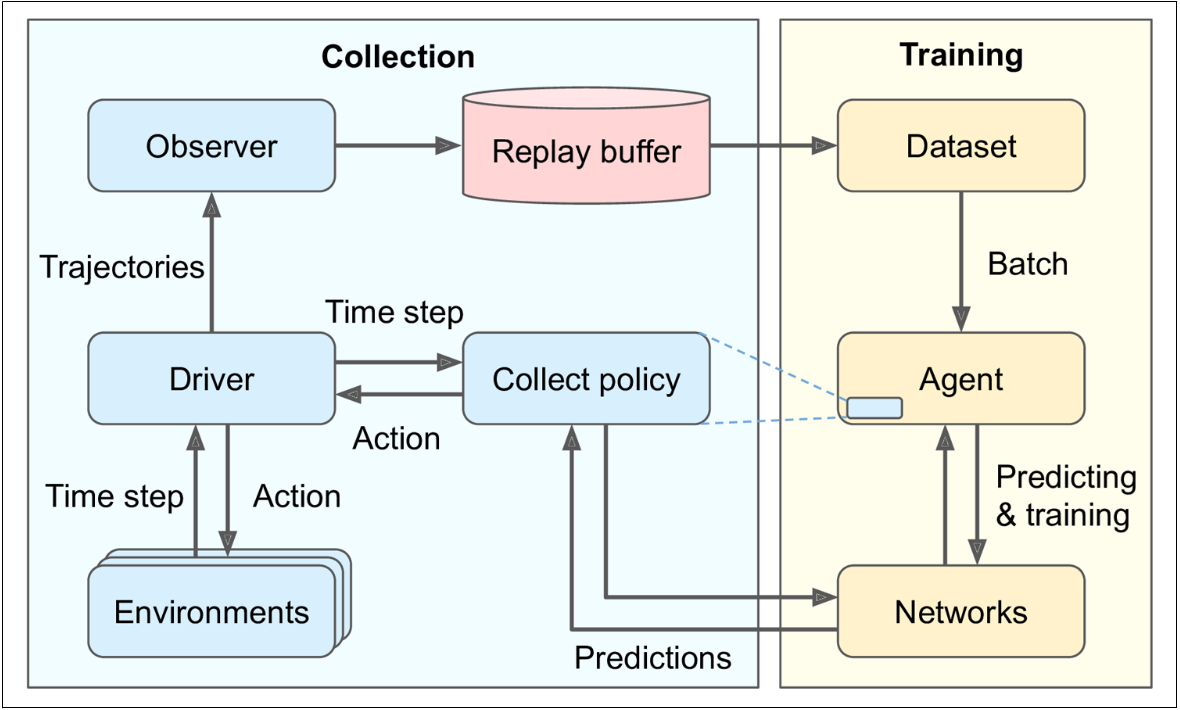

**1. 환경이 여러개인 이유?**   환경을 여러 개 복사하여 GPU로 병렬 탐색하면 빠름 (그 때 그 볼링 훈련 기억나시죠?)

**2. 경로(Trajectories)?**   한 타임스텝에서 다음 타임스텝으로의 전환, 이 경로로 옵저버에게 전달 및 재생 버퍼에 전달됨 (나중에 에이전트가 샘플링해서 훈련에 사용하죠?)

**3. 왜 옵저버가 필요함? 드라이버가 그냥 경로 저장하면 안됨?** 그러면 재생버퍼를 사용하지 않는 것으로 되어, 드라이버가 유연성이 떨어짐 (사용자가 원하는 추가 튜닝이 힘들어짐)

## **6. 심층 Q-네트워크 만들기**
이제 **심층 Q-네트워크 - DQN 에이전트 - 재생 버퍼 - 재생 버퍼에 기록하는 옵저버 - 훈련 지표 몇 개 - 드라이버 - 데이터셋**을 만들어보자

**<구조를 풀어서 설명하자면...>**

1. 입력이 여러개면 일단 각각 **전처리** 시행 (preprocessing_layers)
2. 전처리된 입력을 **연결**해줘야 함 (preprocessing_combiner)
3. **합성곱** 층 리스트 적용 (conv_layer_params)
4. (출력을 위한)** 밀집 층 **적용 (fc_layer_params)
* 필요 시 드롭아웃 층 (dropout_layer_params) 적용 가능

In [ ]:
import keras
import tensorflow as tf

In [ ]:
from tf_agents.networks.q_network import QNetwork #이 Q-Network는 옵저버를 입력으로 받고 행동마다 하나의 Q-가치를 출력함
#그래서 관측 스펙, 행동 스펙을 전달해야 함 (하부의 함수에 observation_spec(), action_spec())

preprocessing_layer = keras.layers.Lambda(
    lambda obs : tf.cast(obs, np.float32) / 255.) #관측값 32비트 실수로 변환 후 0.0에서 1.0 사이 값으로 정규화
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)] #합성곱층 3개 적용 (8*8필터 32개와 스트라이드 4, 4*4필터 64개와 스트라이드 2, 3*3필터 64개와 스트라이드 1 ???)
fc_layer_params=[512] #유닛 512개를 가진 밀집층 적용

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params = fc_layer_params
) 

## **7. DQN 에이전트 만들기**

In [ ]:
from tensorflow.keras import optimizers

In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0) #훈련 스텝 횟수를 셀 변수 만들기
update_period = 4 # 4스텝마다 모델 훈련
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True) #옵티마이저 만들기
                                     #이거 된 사람? 나 tf 붙여야 돌아가던데?
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε e-그리디 정책을 위함
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε 1에서 시작해서 0.01로 점점 줄어듦
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"), #reduction true면 평균을 쳐버린다
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))  #타임 스텝, 행동 스펙, 훈련 Q-network, 옵티마이저, 타깃 모델 훈련 간격, 손실 함수, 할인 계수, train_step 변수, e값 반환 함수
agent.initialize() #초기화

## **8. 재생버퍼와 옵저버 만들기**

**<재생 버퍼의 매개변수 알아보기>**
1. **data_spec** : 재생 버퍼에 저장할 데이터의 구조
2. **batch_size** : 각 스텝에서 추가될 경로 개수 (현재는 스텝마다 하나의 행동 실행하고 하나의 경로를 수집하므로 이 값은 '1')
3. **max_length** : 재생 버퍼의 최대 크기

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000) # reduce if OOM error

replay_buffer_observer = replay_buffer.add_batch #재생 버퍼에 경로를 저장할 옵저버 만들기

In [ ]:
class ShowProgress: #호출될 때마다 카운터를 증가시키는 옵저버 (100번 넘길 때마다 진행과정 표기) -> 마지막 줄을 통해 카운트 출력
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

## **9. 훈련 측정 지표 만들기**

In [ ]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(), #에피소드 횟수
    tf_metrics.EnvironmentSteps(), #환경 내에서 취해진 스텝 횟수
    tf_metrics.AverageReturnMetric(), #에피소드당 평균 리턴
    tf_metrics.AverageEpisodeLengthMetric(), #평균 에피소드 길이
]

In [ ]:
#이걸 확인하려면?
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


## **10. 수집 드라이버 만들기**
**드라이버란?** 주어진 정책으로 환경을 탐색하고 경험을 수집하여 옵저버에게 이를 전파하는 객체
그래서 각 스텝별로...
1. 현재 타임 스텝을 수집 정책에 전달 -> 수집 정책이 타임스텝을 활용해 정책을 선택하고 행동 스텝을 반환
2. 드라이버는 그 행동을 환경에 전달하고 다음 타임 스텝을 반환받음
3. 이 전이를 표현하는 경로 객체를 만들고 모든 옵저버에게 전달

- DynamicStepDriver : 주어진 스텝 횟수에 대한 경험 수집
- DynamicEpisodeDriver : 주어진 에피소드 횟수에 대한 경험 수집


  -> 여기서는 스텝 4개에 대한 경험을 수집하므로 DynamicStepDriver를 만듦

In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # 환경, 수집정책, 옵저버 리스트, 실행할 스텝 횟수 총 4개 전달

In [ ]:
#완전한 랜덤 정책을 위해 사전에 재생버퍼 채워놓기 (20000번 사전 실행)
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) #  80,000 ALE 프레임과 같음
final_time_step, final_policy_state = init_driver.run()

20000/20000

## **11. 데이터셋 만들기**

In [ ]:
trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)
#Get_next : 경로의 배치를 반환하고 샘플 식별자와 샘플링 확률 담은 BufferInfo 반환
#이 코드는 두 경로로 이루어진 스텝 3개를 포함한 배치 반환 // 서브 에피소드 2개를 따로 돌리며, 스텝을 3개를 보여줄려나 봄 // 총 6개의 화면을 보여주며, 그 화면에 FrameStack4에 따라 4개의 진행사항을 보여줌

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [ ]:
trajectories._fields #필드 7개로 이루어진 네임드 튜플

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [ ]:
trajectories.observation.shape #각 스텝의 관측의 크기가 84*84*4이므로 여기에 2개 경로에 대해 스텝 3개를 반영하여 필드의 크기가 [2, 3, 84, 84, 4]

TensorShape([2, 3, 84, 84, 4])

In [ ]:
trajectories.step_type.numpy() #step_type 텐서는 [2, 3] 크기

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

In [ ]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories) #trajectories를 배치 time_step, 배치 action_step, 배치 next_time_step를 담은 리스트로 각각 나눠줌
time_steps.observation.shape
#2번의 전이가 있으므로 전이만 쳐서 3개가 아니라 2개가 됨

TensorShape([2, 2, 84, 84, 4])

In [ ]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)
    #tf.data.Dataset을 활용하고 (as_dataset())
    #훈련 스텝마다 64개 경로의 배치 샘플링
    #각 경로는 2개의 스텝을 포함 (=다음 스텝을 향한 1개의 전이)
    #3개를 병렬로 처리하고, 3개의 배치를 프리페치

## **12. 훈련 반복 만들기**

In [ ]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)
#속도를 빠르게 하기 위해 텐서플로 함수를 사용
#tf_agents.utils.common을 불러온 후
#각 함수를 function()으로 감싸기

In [ ]:
def train_agent(n_iterations): #n_iterations동안 실행할 함수
    time_step = None 
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    #초기상태화(None이라던지, 상태가 없는 policy라던지)
    #dataset iteration 설정 -> 후에 next 함수로 iteration 돌림 https://dojang.io/mod/page/view.php?id=2408
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state) #현재 타입 스텝과 정책 상태를 전달하여 run -> 4스텝동안 경험 수집
        trajectories, buffer_info = next(iterator) #수집된 경로를 재생 버퍼와 지표로 전달
        train_loss = agent.train(trajectories) # #경로를 train 메서드에 전달 -> 훈련손실 반환
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="") #반복횟수와 훈련 손실 출력
        if iteration % 1000 == 0:
            log_metrics(train_metrics) #1000번 반복 시마다 로그 기록

In [44]:
train_agent(10000)

INFO:absl: 
		 NumberOfEpisodes = 225
		 EnvironmentSteps = 40004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 179.39999389648438


995 loss:0.00017

INFO:absl: 
		 NumberOfEpisodes = 248
		 EnvironmentSteps = 44004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 195.89999389648438


1998 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 268
		 EnvironmentSteps = 48004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 185.1999969482422


2999 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 287
		 EnvironmentSteps = 52004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 193.3000030517578


3995 loss:0.00018

INFO:absl: 
		 NumberOfEpisodes = 309
		 EnvironmentSteps = 56004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 168.10000610351562


4997 loss:0.00018

INFO:absl: 
		 NumberOfEpisodes = 331
		 EnvironmentSteps = 60004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 159.6999969482422


5997 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 352
		 EnvironmentSteps = 64004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 185.8000030517578


6996 loss:0.00019

INFO:absl: 
		 NumberOfEpisodes = 373
		 EnvironmentSteps = 68004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 194.0


7998 loss:0.00028

INFO:absl: 
		 NumberOfEpisodes = 396
		 EnvironmentSteps = 72004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 174.0


8998 loss:0.00276

INFO:absl: 
		 NumberOfEpisodes = 416
		 EnvironmentSteps = 76004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 164.0


9999 loss:0.00106